Celem zadania było przygotowanie modelu przewidującego, czy dana osoba jest zamężna na podstawie wybranych samodzielnie zmiennych, wykorzystując dane z badania 'How Couples Meet and Stay Together' przeprowadzonego przez Stanford University w 2017 roku. Dla wybranych ciągłych predyktorów należało narysować profile Ceteris Paribus.

Jako model wybrano `xgboost` z domyślnymi hiperparametrami.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from xgboost import XGBClassifier

In [2]:
path = r'D:\Interpretable Machine Learning\PD1\HCMST 2017 fresh sample for public sharing draft v1.1.dta'
data = pd.read_stata(path)

In [3]:
data.shape

(3510, 285)

Wybrane zmienne to:
* `ppage` - wiek - zmienna "ciągła",
* `w6_q24_length` - liczba znaków w odpowiedzi na pytanie o historię znajomości z partnerem - zmienna "ciągła",
* `w6_sex_frequency` - w ciągu ostatnich 12 miesięcy, mniej więcej jak często uprawiałeś seks z partnerem? - zmienna porządkowa,
* `w6_q23` - kto zarabiał więcej w 2016 lub kiedy ostatnio byliście razem? - zmienna jakościowa,
* `w6_q27` - czy wraz z partnerem dorastaliście w tej samej miejscowości? - zmienna jakościowa.

## Eksploracja danych

## `S1`

In [4]:
data.S1.value_counts()

Yes, I am Married       2085
No, I am not Married    1425
Name: S1, dtype: int64

In [5]:
data.S1.isna().sum()

0

Klasy są w miarę zbalansowane. Nie ma brakujących wartości w zmiennej objaśnianej.

In [6]:
data.S1.head()

0    No, I am not Married
1       Yes, I am Married
2       Yes, I am Married
3    No, I am not Married
4       Yes, I am Married
Name: S1, dtype: category
Categories (2, object): [Yes, I am Married < No, I am not Married]

In [7]:
data.S1.cat.codes.head()

0    1
1    0
2    0
3    1
4    0
dtype: int8

Kodowanie jest "odwrócone", raczej wolelibyśmy, żeby 1 pojawiała się dla osób w związku małżeńskim.

## `ppage`

In [8]:
data.ppage.astype(float).describe()

count    3510.000000
mean       48.793732
std        16.942535
min        18.000000
25%        34.000000
50%        50.000000
75%        62.000000
max        93.000000
Name: ppage, dtype: float64

Po `count` widać, że nie ma brakujących wartości.

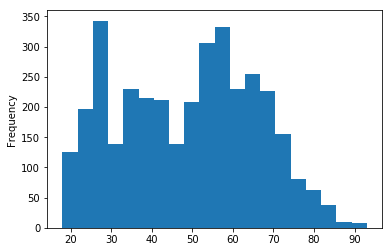

In [9]:
data.ppage.astype(float).plot('hist', bins=20)

<hr>

## `w6_q24_length`

In [10]:
data.w6_q24_length.astype(float).describe()

count    3394.000000
mean      182.854449
std       236.993300
min         0.000000
25%        54.000000
50%       124.000000
75%       222.750000
max      3855.000000
Name: w6_q24_length, dtype: float64

In [11]:
data.w6_q24_length.isna().sum()

116

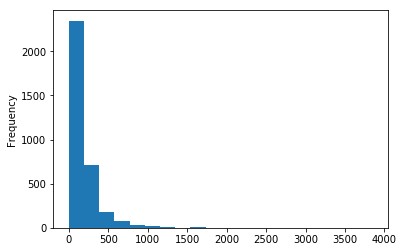

In [12]:
data.w6_q24_length.astype(float).plot('hist', bins=20)

Mediana równa 124 znaki oznacza, że respondenci raczej nie pisali długich historii. Raczej spodziewalibyśmy się mocno skośnego rozkładu.

<hr>

## `w6_sex_frequency`

In [13]:
data.w6_sex_frequency.value_counts()

Once a month or less    969
Once or twice a week    744
2 to 3 times a month    519
3 to 6 times a week     368
Refused                 170
Once a day or more       86
Name: w6_sex_frequency, dtype: int64

In [14]:
data.w6_sex_frequency.isna().sum()

654

Tutaj jest więcej brakujących wartości.

In [15]:
data.w6_sex_frequency.unique()

[NaN, Once a month or less, 2 to 3 times a month, 3 to 6 times a week, Once or twice a week, Once a day or more, Refused]
Categories (6, object): [Refused < Once a day or more < 3 to 6 times a week < Once or twice a week < 2 to 3 times a month < Once a month or less]

In [16]:
data.w6_sex_frequency.unique().codes

array([-1,  5,  4,  2,  3,  1,  0], dtype=int8)

Ta zmienna jest porządkowa, więc można zachować kodowanie za pomocą liczb całkowitych. Algorytmowi opartemu na drzewach to nie przeszkodzi, dopóki kolejność będzie zachowana.

<hr>

## `w6_q23`

In [17]:
data.w6_q23.value_counts()

I earned more                             1382
[Partner Name] earned more                1328
We earned about the same amount            451
[Partner Name] was not working for pay     203
Refused                                     30
Name: w6_q23, dtype: int64

In [18]:
data.w6_q23.isna().sum()

116

<hr>

## `w6_q27`

In [19]:
data.w6_q27.value_counts()

No         2610
Yes         774
Refused      10
Name: w6_q27, dtype: int64

In [20]:
data.w6_q27.isna().sum()

116

<hr>

Czy te 116 brakujących wartości (w zmiennych `w6_q24_length`, `w6_q23` i `w6_q27`) dotyczy tych samych rekordów? Tak!

In [21]:
sum(data.w6_q24_length.isna() != data.w6_q23.isna()) + sum(data.w6_q24_length.isna() != data.w6_q27.isna())

0

## Przygotowanie danych

Po przyjrzeniu się wybranym zmiennym, postanowiłem dokonać następujących transformacji:
* odwrócić kodowanie w zmiennej `S1` - 1 jeśli w związku małżeńskim, 0 jeśli nie,
* usunać 116 obserwacji, gdzie brakuje `w6_q24_length`, `w6_q23` i `w6_q27`,
* usunąć obserwacje, gdzie w powyższych trzech zmiennych wartość to 'Refused',
* dla `w6_sex_frequency` potraktować 'Refused' jako brakującą wartość + imputacja za pomocą najczęstszej wartości - 'Once a month or less',
* One Hot Encoding dla zmiennych `w6_q23` i `w6_q27`.

In [22]:
variables = ['ppage', 'w6_q24_length', 'w6_sex_frequency', 'w6_q23', 'w6_q27']
# Selecting variables
X = data[variables]
# Filtering observations
logical_filter = (~data.w6_q23.isna()) & (data.w6_q23 != 'Refused') & (data.w6_q27 != 'Refused')
X = X[logical_filter]
# Casting types and imputation
X.ppage = X.ppage.astype(float)
X.w6_q24_length = X.w6_q24_length.astype(float)
X.w6_sex_frequency = X.w6_sex_frequency.cat.codes.replace({-1:5, 0:5})
X.w6_q23 = X.w6_q23.astype(str)
X.w6_q27 = X.w6_q27.astype(str)
# One Hot Encoding
X = pd.get_dummies(X)
X.columns = map(lambda x: x.replace('[Partner Name]', 'PARTNER'), X.columns)

y = 1 - data.S1.cat.codes
y = y[logical_filter]

In [23]:
X.head()

,ppage,w6_q24_length,w6_sex_frequency,w6_q23_I earned more,w6_q23_We earned about the same amount,w6_q23_PARTNER earned more,w6_q23_PARTNER was not working for pay,w6_q27_No,w6_q27_Yes
0,30.0,232.0,5,1,0,0,0,1,0
1,55.0,213.0,5,0,0,1,0,1,0
2,47.0,87.0,4,1,0,0,0,1,0
3,28.0,80.0,5,1,0,0,0,1,0
4,59.0,648.0,2,0,0,1,0,1,0


## Trenowanie modelu

In [24]:
xgb = XGBClassifier(seed=123)
xgb.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
       silent=True, subsample=1)

Nie optymalizowałem hiperparametrów w żaden sposób i nie robiłem żadnej kroswalidacji, ponieważ 

# Profile Ceteris Paribus

Poniższa implementacja rysuje profil Ceteris Paribus dla podanego modelu (`model`), obserwacji (`obs`) i wybranej zmiennej (`var`). Predykcje obliczane są dla zadanej liczby punktów (`no_points`) równorozłożonych w rozstępie zmiennej `var` w podanym zbiorze `X`. Można ograniczyć z góry brany pod uwagę przedział wartości zmiennej. Wartość zanotowana dla wybranej obserwacji jest zaznaczona czerwoną kropką.

In [25]:
def cp_profile(model, obs, var, X, no_points, xmax=None):
    # Prepare dataframe for prediction
    obs = pd.DataFrame(obs).transpose()
    df = pd.concat([obs]*no_points)
    if xmax:
        df[var] = np.linspace(X[var].min(), xmax, no_points)
    else:
        df[var] = np.linspace(X[var].min(), X[var].max(), no_points)
    # Produce predictions
    preds = model.predict_proba(df)[:,1]
    # Create CP profile
    plt.plot(df[var], preds, 'grey')
    plt.xlabel(var)
    plt.ylabel('Probability of being married')
    plt.title('Ceteris Paribus profile for variable ' + var)
    plt.scatter(obs[var], model.predict_proba(obs)[:,1], c=(0.8,0,0))
    
    plt.show()

Jako przykładową obserwację wybrano 32-letnią osobę, która o poznaniu swojego partnera napisała 348 znaków. Z partnerem uprawiała seks z partnerem 3 do 6 razy w tygodniu; w 2016 roku zarobiła więcej niż partner oraz dorastała z partnerem w tej samej miejscowości. Osoba ta nie była w związku małżeńskim.

In [26]:
obs = X.iloc[23,]
print(obs)
print(y[23])

ppage                                      32.0
w6_q24_length                             348.0
w6_sex_frequency                            2.0
w6_q23_I earned more                        1.0
w6_q23_We earned about the same amount      0.0
w6_q23_PARTNER earned more                  0.0
w6_q23_PARTNER was not working for pay      0.0
w6_q27_No                                   0.0
w6_q27_Yes                                  1.0
Name: 24, dtype: float64
0


## `ppage`

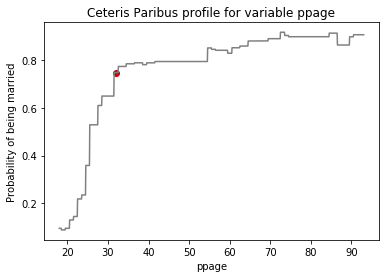

In [27]:
cp_profile(xgb, X.iloc[23, ], 'ppage', X, 1000)

Prawdopodobieństwo pozostawania w związku małżeńskim wzrasta wraz z wiekiem. Wydaje się to sensowne - bardziej u starszych niż u młodszych ludzi może dominować tradycyjny model rodziny.

## `w6_q24_length`

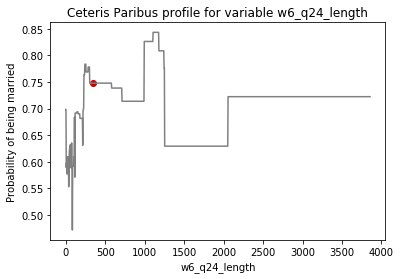

In [28]:
cp_profile(xgb, X.iloc[23, ], 'w6_q24_length', X, 1000)

Największe zróżnicowanie występuje tam, gdzie skoncentrowany był rozkład zmiennej `w6_q24_length` - dla mniejszych wartości. Na powyższym wykresie ciekawą obserwacją jest, że 'optymalna' długość opowieści o znajomości z punktu widzenia pozostawania w związku małżeńskim to nieco ponad 1000 znaków.

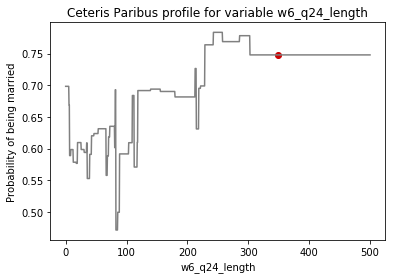

In [29]:
cp_profile(xgb, X.iloc[23, ], 'w6_q24_length', X, 1000, 500)

Zmniejszyłem zakres, żeby uwidocznić wahanie profilu CP dla mniejszych wartości. Tutaj widać mocno nieliniową zalezność.